In [1]:
from google.colab import drive
drive.mount('/b05501039@g.ntu.edu.tw/')  #登入google帳戶以讀存取資料

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /b05501039@g.ntu.edu.tw/


In [2]:
%tensorflow_version 1.x  #切換tf版本(colab指令)
import tensorflow as tf
gpu_device_name = tf.test.gpu_device_name()
print(gpu_device_name) #確定device name
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess) #查看使用中的GPU

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  #切換tf版本(colab指令)`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
/device:GPU:0
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import RMSprop, Adam
from keras.layers import LSTM, Activation, CuDNNLSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from sklearn.externals import joblib  # save scaler
import time
from random import shuffle
import os
from scipy.stats import norm


In [5]:
print("-----0.2g-----")
print('無基線修正總data:914, train:639, test:275')
print('有基線修正總data:718, train:502, test:216')
print('training set:1141, testing:491')
print("-----0.3g-----")
print('無基線修正總data:655, train:458, test:194')
print('有基線修正總data:485, train:339, test:146')
print('training set:797, testing:340')
print("-----0.4g-----")
print('無基線修正總data:518, train:362, test:156')
print('有基線修正總data:343, train:240, test:103')
print('training set:602, testing:259')


-----0.2g-----
無基線修正總data:914, train:639, test:275
有基線修正總data:718, train:502, test:216
training set:1141, testing:491
-----0.3g-----
無基線修正總data:655, train:458, test:194
有基線修正總data:485, train:339, test:146
training set:797, testing:340
-----0.4g-----
無基線修正總data:518, train:362, test:156
有基線修正總data:343, train:240, test:103
training set:602, testing:259


In [6]:
def ScalingInput(train,test):
    train_flatten = np.reshape(train, [train.shape[0]*train.shape[1]*train.shape[2],1])  
    test_flatten = np.reshape(test, [test.shape[0]*test.shape[1]*test.shape[2],1]) 
    scaler_X = MinMaxScaler(feature_range=(-1, 1))  #標準化器
    scaler_X.fit(train_flatten)  #對應到要縮放的資料
    train_flatten_map = scaler_X.transform(train_flatten)  
    train_map = np.reshape(train_flatten_map, [train.shape[0], train.shape[1], train.shape[2]]) 
    test_flatten_map = scaler_X.transform(test_flatten)  
    test_map = np.reshape(test_flatten_map, [test.shape[0], test.shape[1], test.shape[2]]) 
    return train_map, test_map, scaler_X
 
def ScalingOutput(train,test):
    train_flatten = np.reshape(train, [train.shape[0]*train.shape[1] ,train.shape[2]])  
    test_flatten = np.reshape(test, [test.shape[0]*test.shape[1], test.shape[2]]) 
    scaler_y = MinMaxScaler(feature_range=(-1, 1))  #標準化器
    scaler_y.fit(train_flatten)  #對應到要縮放的資料
    train_flatten_map = scaler_y.transform(train_flatten)  
    train_map = np.reshape(train_flatten_map, [train.shape[0], train.shape[1], train.shape[2]]) 
    test_flatten_map = scaler_y.transform(test_flatten)  
    test_map = np.reshape(test_flatten_map, [test.shape[0], test.shape[1], test.shape[2]]) 
    return train_map, test_map, scaler_y
    
def prediction(X_scale_stack,y_scale_stack,scaler_y_Disp):
  pred = model.predict(X_scale_stack) 
  pred_flatten = np.reshape(pred, [pred.shape[0]*pred.shape[1], pred.shape[2]])  
  pred = scaler_y_Disp.inverse_transform(pred_flatten)  #將預測數值縮放回原大小 
  pred = np.reshape(pred, [y_scale_stack.shape[0], y_scale_stack.shape[1], y_scale_stack.shape[2]])  
  return pred

def MSE(Response_true,Response_pred):
  ErrorList=[]
  for i in range(Response_true.shape[0]):
      for k in range(Response_true.shape[2]):
        true_std = (Response_true[i,:,k] - Response_true[i,:,k].min()) / (Response_true[i,:,k].max() - Response_true[i,:,k].min())
        true_scaled = true_std * (1-(-1)) + (-1)
        pred_std = (Response_pred[i,:,k] - Response_true[i,:,k].min()) / (Response_true[i,:,k].max() - Response_true[i,:,k].min())
        pred_scaled = pred_std * (1-(-1)) + (-1)

        ErrorList.append( sum((pred_scaled- true_scaled)**2)/Response_true.shape[1] ) 
  Mse = np.array(ErrorList).reshape(Response_true.shape[0],Response_true.shape[2])
  return Mse


In [23]:
#-------------------------------------------------------------------------------
# Load training data and validation data

dataDir02g = '/b05501039@g.ntu.edu.tw/My Drive/AI center intern/nonlinear_seismic_response_analysis/August/0.2g_Earthquake/' 
dataDir03g = '/b05501039@g.ntu.edu.tw/My Drive/AI center intern/nonlinear_seismic_response_analysis/August/0.3g_Earthquake/' 
dataDir04g = '/b05501039@g.ntu.edu.tw/My Drive/AI center intern/nonlinear_seismic_response_analysis/August/0.4g_Earthquake/' 
resultDir = '/b05501039@g.ntu.edu.tw/My Drive/AI center intern/nonlinear_seismic_response_analysis/August/0.2g_Earthquake/Disp/0.2gDisp9/'  
mat_data02g = scipy.io.loadmat(dataDir02g+'NewData_Disp.mat')
mat_data03g = scipy.io.loadmat(dataDir03g+'NewData_Disp.mat')
mat_data04g = scipy.io.loadmat(dataDir04g+'NewData_Disp.mat')
mat_analysis = scipy.io.loadmat(dataDir02g+'Disp02g_Analysis.mat')
mat_index03g = scipy.io.loadmat(dataDir03g+'Disp03g_Index.mat')
mat_index04g = scipy.io.loadmat(dataDir04g+'Disp04g_Index.mat')

TrainGoodInd = mat_analysis['TrainGoodInd'][8][0][0]
TestGoodInd = mat_analysis['TestGoodInd'][8][0][0]
TrainBaddInd = mat_analysis['TrainBadInd'][8][0][0]
TestBaddInd = mat_analysis['TestBadInd'][8][0][0]
Traingoodindex03g = mat_index03g['Traingoodindex03g'][0]
Traingoodindex04g = mat_index04g['Traingoodindex04g'][0]

# original data
X_train_stack = mat_data02g['X_train_stack'][TrainGoodInd]
y_Disp_train_stack = mat_data02g['y_Disp_train_stack'][TrainGoodInd]
X_test_stack = mat_data02g['X_test_stack'][TestGoodInd]
y_Disp_test_stack = mat_data02g['y_Disp_test_stack'][TestGoodInd]

y_Disp_train_stack_Bad = mat_data02g['y_Disp_train_stack'][TrainBaddInd]
y_Disp_test_stack_Bad = mat_data02g['y_Disp_test_stack'][TestBaddInd]
#0.3g
X_train_stack03g = mat_data03g['X_train_stack'][Traingoodindex03g]
y_Disp_train_stack03g = mat_data03g['y_Disp_train_stack'][Traingoodindex03g]
#0.4g
X_train_stack04g = mat_data04g['X_train_stack'][Traingoodindex04g]
y_Disp_train_stack04g = mat_data04g['y_Disp_train_stack'][Traingoodindex04g]

# original data
X_train_scale_stack, X_test_scale_stack, scaler_X = ScalingInput(X_train_stack,X_test_stack)
y_Disp_train_scale_stack, y_Disp_test_scale_stack, scaler_y_Disp = ScalingOutput(y_Disp_train_stack,y_Disp_test_stack)
#0.3g
X_train_scale_stack, X_train_scale_stack_03g, scaler_X_03g = ScalingInput(X_train_stack,X_train_stack03g)
y_Disp_train_scale_stack, y_Disp_train_scale_stack_03g, scaler_y_Disp_03g = ScalingOutput(y_Disp_train_stack,y_Disp_train_stack03g)
#0.4g
X_train_scale_stack, X_train_scale_stack_04g, scaler_X_04g = ScalingInput(X_train_stack,X_train_stack04g)
y_Disp_train_scale_stack, y_Disp_train_scale_stack_04g, scaler_y_Disp_04g = ScalingOutput(y_Disp_train_stack,y_Disp_train_stack04g)


# earthquake
name_train = mat_data02g['name_train']
name_test = mat_data02g['name_test']
steps_train = mat_data02g['step_train']
steps_test = mat_data02g['step_test']




In [8]:
model = load_model(resultDir+'best_model.h5')
'''scaler_X = joblib.load(dataDir+'scaler_X.save')
scaler_y = joblib.load(dataDir+'scaler_y_Acc.save')'''
# Predict Training data and Testing data  
y_Disp_train_stack_pred = prediction(X_train_scale_stack,y_Disp_train_scale_stack,scaler_y_Disp)
y_Disp_test_stack_pred = prediction(X_test_scale_stack, y_Disp_test_scale_stack,scaler_y_Disp)
#0.3g
y_Disp_test_stack_pred_03g = prediction(X_train_scale_stack_03g, y_Disp_train_scale_stack_03g,scaler_y_Disp_03g)
#0.4g
y_Disp_test_stack_pred_04g = prediction(X_train_scale_stack_04g, y_Disp_train_scale_stack_04g,scaler_y_Disp_04g)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [9]:
Train_MSE = MSE(y_Disp_train_stack,y_Disp_train_stack_pred)
Test_MSE = MSE(y_Disp_test_stack,y_Disp_test_stack_pred)
#0.3g
Train_MSE03g = MSE(y_Disp_train_stack03g,y_Disp_test_stack_pred_03g)
#0.4g
Train_MSE04g = MSE(y_Disp_train_stack04g,y_Disp_test_stack_pred_04g)

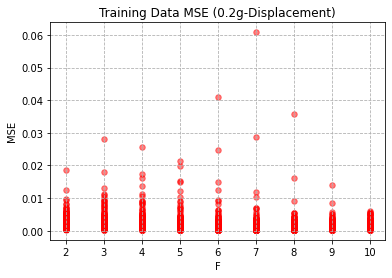

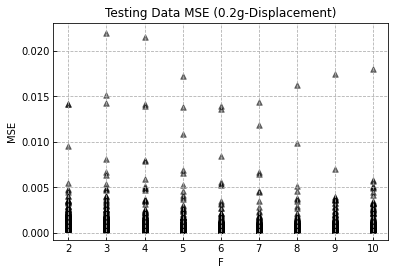

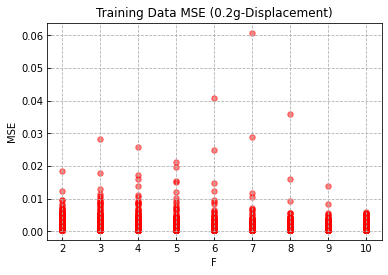

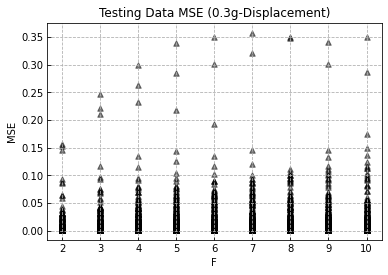

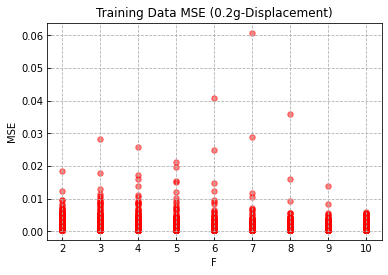

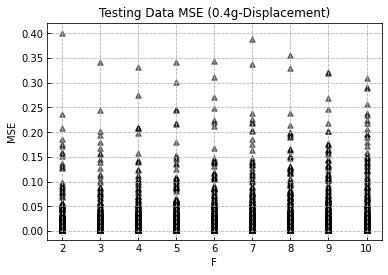

In [10]:
## Normalized MSE
plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Train_MSE.shape[0])+i).astype(np.int8),Train_MSE[:,i-1],s=30,c='red',marker='o',alpha=0.5,)
plt.title('Training Data MSE (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('MSE')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Test_MSE.shape[0])+i).astype(np.int8),Test_MSE[:,i-1],s=30,c='black',marker='^',alpha=0.5,)
plt.title('Testing Data MSE (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('MSE')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

## 0.3g Normalized MSE
plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Train_MSE.shape[0])+i).astype(np.int8),Train_MSE[:,i-1],s=30,c='red',marker='o',alpha=0.5,)
plt.title('Training Data MSE (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('MSE')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Train_MSE03g.shape[0])+i).astype(np.int8),Train_MSE03g[:,i-1],s=30,c='black',marker='^',alpha=0.5,)
plt.title('Testing Data MSE (0.3g-Displacement)')
plt.xlabel('F')
plt.ylabel('MSE')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

## 0.4g Normalized MSE
plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Train_MSE.shape[0])+i).astype(np.int8),Train_MSE[:,i-1],s=30,c='red',marker='o',alpha=0.5,)
plt.title('Training Data MSE (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('MSE')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Train_MSE04g.shape[0])+i).astype(np.int8),Train_MSE04g[:,i-1],s=30,c='black',marker='^',alpha=0.5,)
plt.title('Testing Data MSE (0.4g-Displacement)')
plt.xlabel('F')
plt.ylabel('MSE')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')


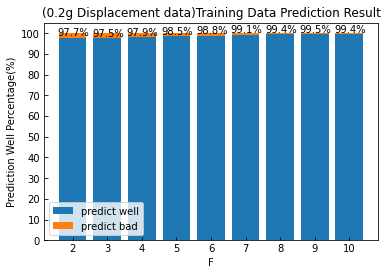

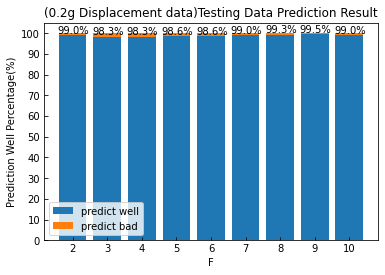

In [11]:
# 繪製MSE百分比圖
PerformanceIndex = 0.005

MSEList = [[Train_MSE,'(0.2g Displacement data)Training'],[Test_MSE,'(0.2g Displacement data)Testing']]
for sample in MSEList:  
  GoodList = []
  BadList = []
  for i in range(9):
    StoryMSE = sample[0][:,i]
    GoodData = StoryMSE[StoryMSE<=PerformanceIndex]
    GoodList.append(GoodData.shape[0]/StoryMSE.shape[0]*100)
    BadList.append(100 - GoodData.shape[0] / StoryMSE.shape[0]*100)

  x = np.arange(9)+2
  plt.figure()
  plt.bar(x, GoodList, label='predict well')
  plt.bar(x, BadList, bottom=GoodList,label='predict bad')
  for xy in zip(x, GoodList):
    plt.annotate("%.1f" %xy[1]+'%', xy=xy, xytext=(-15, 2), textcoords='offset points')
  plt.title(sample[1]+' Data Prediction Result')
  plt.xlabel('F')
  plt.ylabel('Prediction Well Percentage(%)')
  plt.xticks(x)
  plt.yticks(np.arange(0, 105, 10))
  plt.legend(loc = 'lower left') 
  plt.show()


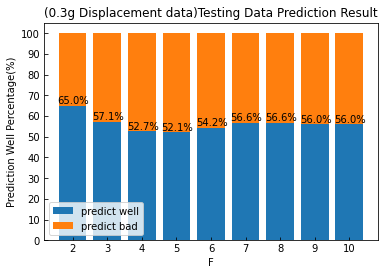

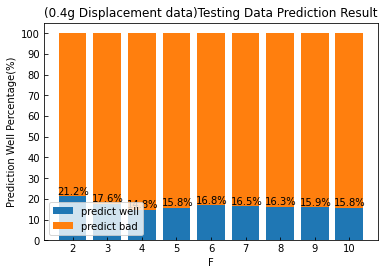

In [12]:
# 繪製0.3gMSE百分比圖
PerformanceIndex = 0.005

MSEList = [[Train_MSE03g,'(0.3g Displacement data)Testing'],[Train_MSE04g,'(0.4g Displacement data)Testing']]
for sample in MSEList:  
  GoodList = []
  BadList = []
  for i in range(9):
    StoryMSE = sample[0][:,i]
    GoodData = StoryMSE[StoryMSE<=PerformanceIndex]
    GoodList.append(GoodData.shape[0]/StoryMSE.shape[0]*100)
    BadList.append(100 - GoodData.shape[0] / StoryMSE.shape[0]*100)

  x = np.arange(9)+2
  plt.figure()
  plt.bar(x, GoodList, label='predict well')
  plt.bar(x, BadList, bottom=GoodList,label='predict bad')
  for xy in zip(x, GoodList):
    plt.annotate("%.1f" %xy[1]+'%', xy=xy, xytext=(-15, 2), textcoords='offset points')
  plt.title(sample[1]+' Data Prediction Result')
  plt.xlabel('F')
  plt.ylabel('Prediction Well Percentage(%)')
  plt.xticks(x)
  plt.yticks(np.arange(0, 105, 10))
  plt.legend(loc = 'lower left') 
  plt.show()

## Arrange index (bad to good)

In [13]:
top_Test = []
top_Train = []
for i in range(9):
  print('%d樓最大MSE Testing data index: '%(i+2),np.argmax(Test_MSE[:,i]))
  print('%d最大MSE Training data index: '%(i+2),np.argmax(Train_MSE[:,i]))
  
  sort_test = Test_MSE[:,i].copy()
  sort_test.sort()
  sort_train = Train_MSE[:,i].copy()
  sort_train.sort()
  for j in range(1,sort_test.size+1):
    top_Test.append(np.where(Test_MSE[:,i]==sort_test[-j])[0][0])
  for k in range(1,sort_train.size+1):
    top_Train.append(np.where(Train_MSE[:,i]==sort_train[-k])[0][0])
top_Test = np.array(top_Test).reshape(Test_MSE.shape[1],Test_MSE.shape[0])  #[樓層,資料數]
top_Train = np.array(top_Train).reshape(Train_MSE.shape[1],Train_MSE.shape[0])  #[樓層,資料數]


2樓最大MSE Testing data index:  222
2最大MSE Training data index:  481
3樓最大MSE Testing data index:  333
3最大MSE Training data index:  481
4樓最大MSE Testing data index:  333
4最大MSE Training data index:  481
5樓最大MSE Testing data index:  333
5最大MSE Training data index:  961
6樓最大MSE Testing data index:  222
6最大MSE Training data index:  252
7樓最大MSE Testing data index:  222
7最大MSE Training data index:  252
8樓最大MSE Testing data index:  222
8最大MSE Training data index:  252
9樓最大MSE Testing data index:  222
9最大MSE Training data index:  252
10樓最大MSE Testing data index:  222
10最大MSE Training data index:  196


In [17]:
#-------------------------------------------------------------------------------
# Plot testing 
F = 10  #(輸入待觀察樓層)
F = F-2
for sample in top_Test[F,0:50]:  #先看部分data
  plt.figure()
  plt.plot(y_Disp_test_stack[sample][:, F], label='True')
  plt.plot(y_Disp_test_stack_pred[sample][:, F], label='Predict')
  plt.title('(0.2g) %dF Displacement '%(F+2)+name_test[sample])
  plt.xlabel('%.2f (sec)'%(0.05))
  plt.ylabel('$Displacement\ (mm)$')
  plt.rcParams['xtick.direction'] = 'in'
  plt.rcParams['ytick.direction'] = 'in'
  plt.grid(linestyle='--')
  plt.legend()

Output hidden; open in https://colab.research.google.com to view.

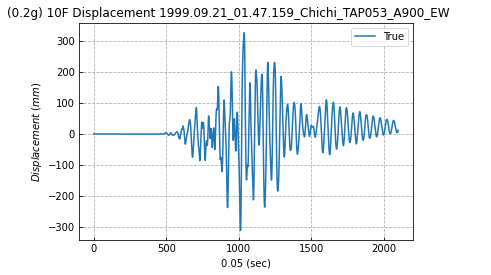

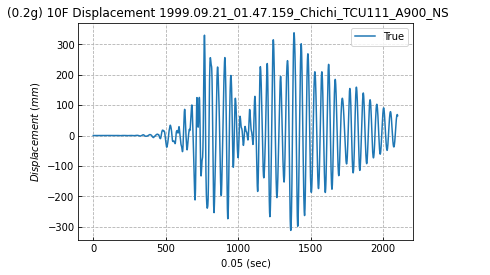

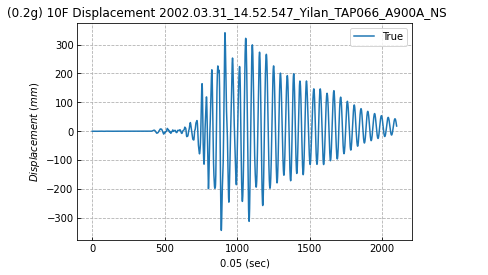

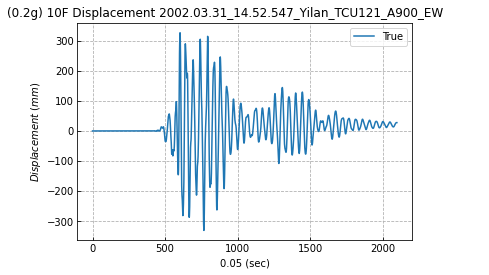

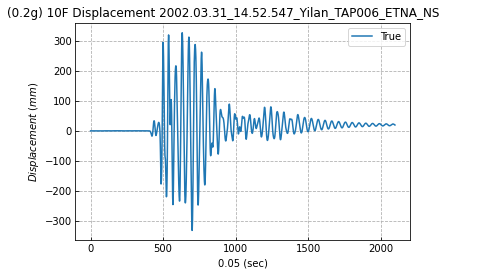

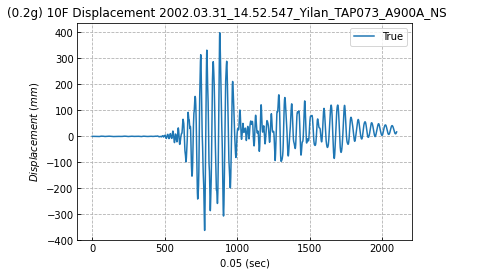

In [38]:
#-------------------------------------------------------------------------------
# Plot testing 
F = 10  #(輸入待觀察樓層)
F = F-2
for i in np.where(Nonlinearity_Good>20)[0]:  #先看部分data
  plt.figure()
  plt.plot(y_Disp_test_stack[i][:, F], label='True')
  plt.title('(0.2g) %dF Displacement '%(F+2)+name_test[i])
  plt.xlabel('%.2f (sec)'%(0.05))
  plt.ylabel('$Displacement\ (mm)$')
  plt.rcParams['xtick.direction'] = 'in'
  plt.rcParams['ytick.direction'] = 'in'
  plt.grid(linestyle='--')
  plt.legend()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

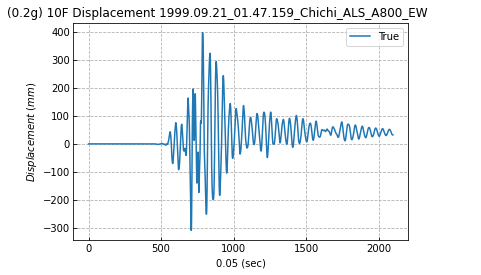

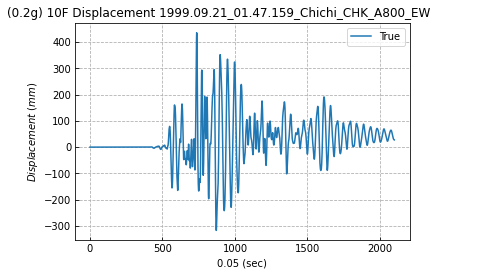

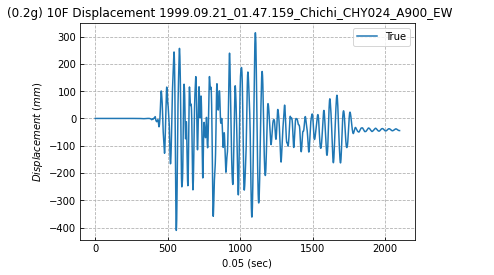

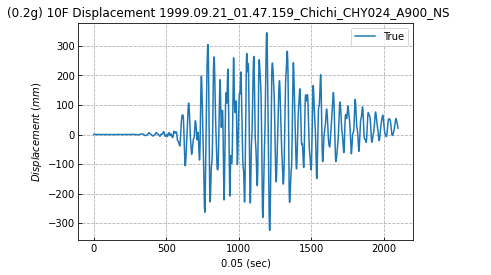

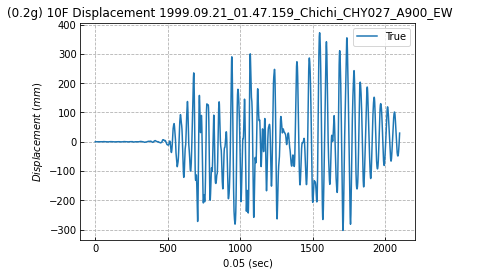

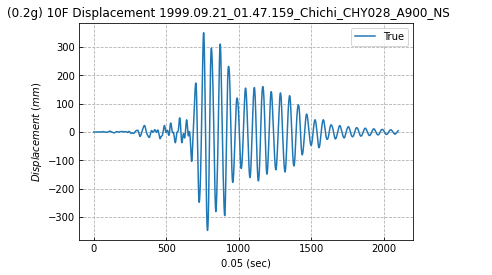

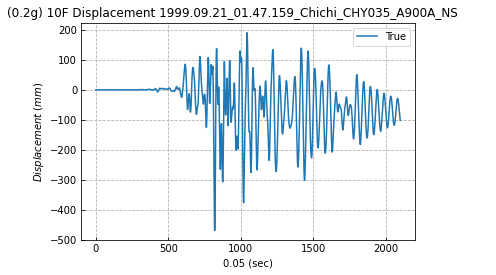

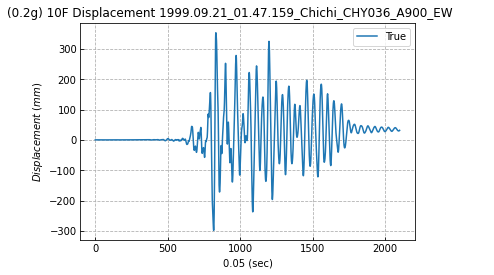

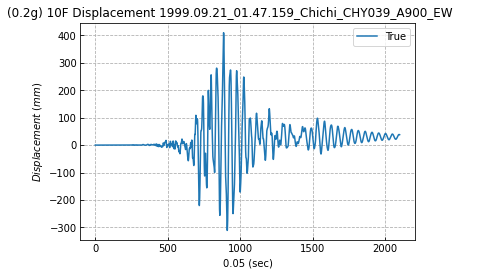

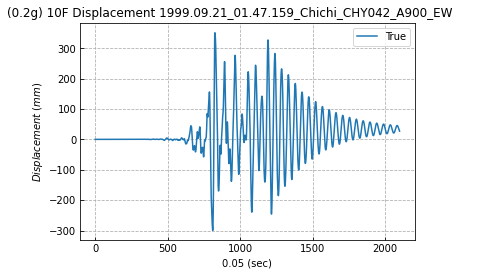

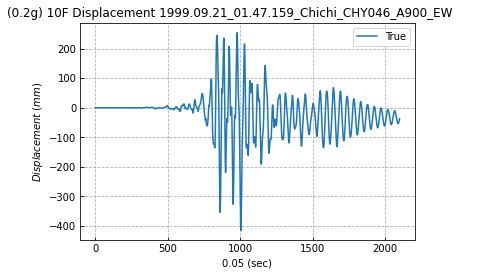

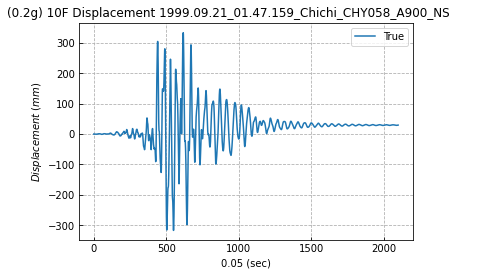

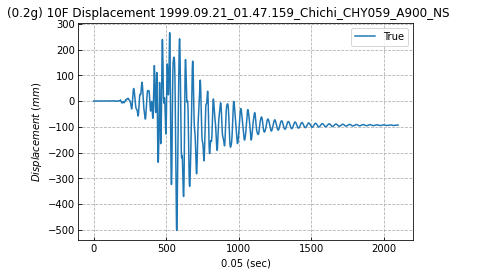

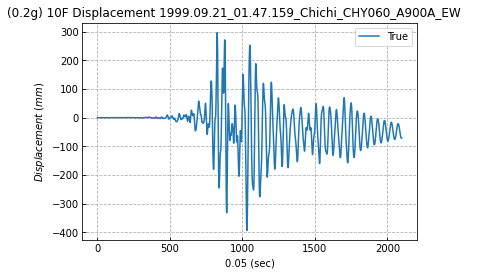

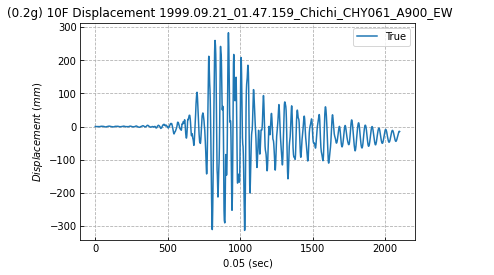

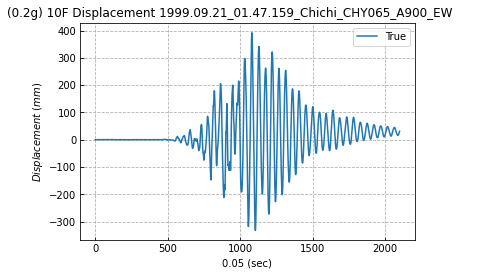

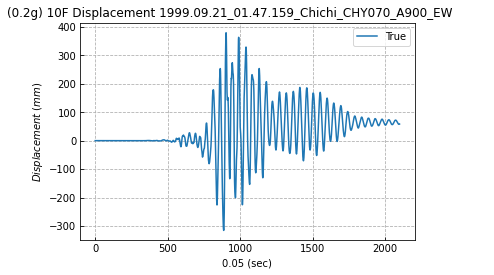

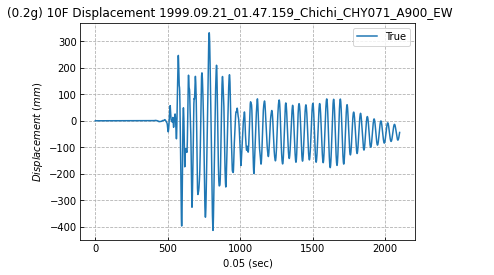

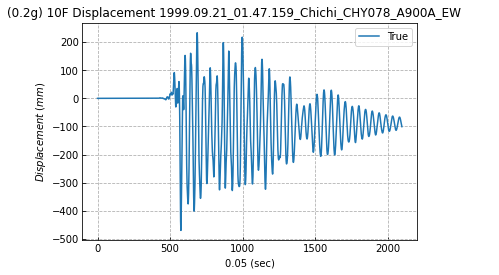

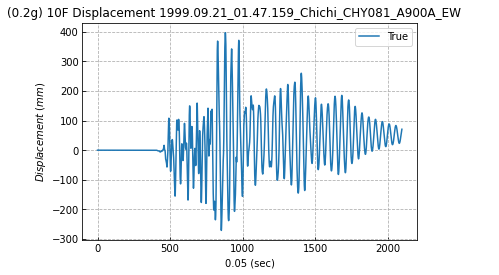

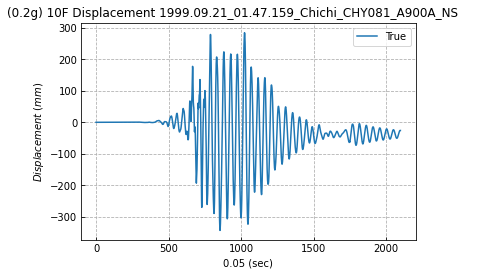

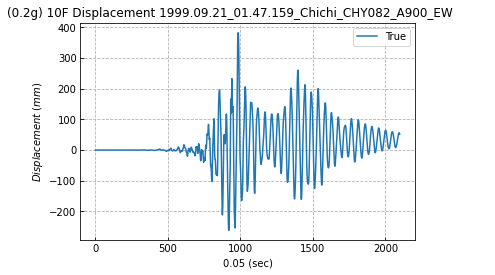

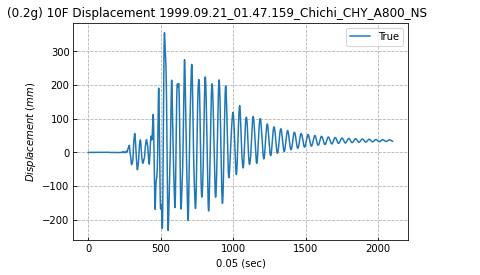

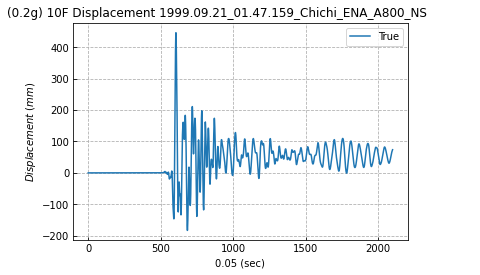

In [26]:
for i in range(y_Disp_test_stack_Bad.shape[0]-50):  #先看部分data
  plt.figure()
  plt.plot(y_Disp_test_stack_Bad[i][:, F], label='True')
  plt.title('(0.2g) %dF Displacement '%(F+2)+name_test[i])
  plt.xlabel('%.2f (sec)'%(0.05))
  plt.ylabel('$Displacement\ (mm)$')
  plt.rcParams['xtick.direction'] = 'in'
  plt.rcParams['ytick.direction'] = 'in'
  plt.grid(linestyle='--')
  plt.legend()

In [48]:
def DegreeOfNonlinear(Displacement):
  PermanentDisp = []
  for i in range(Displacement.shape[0]):
    temp = Displacement[i][1800:-1,8]
    InexMax = np.argmax(temp)
    InexMin = np.argmin(temp)
    length = abs(InexMax-InexMin)
    AVG_nonlineraity = np.average(Displacement[i][-1-5*length:-1,8])
    PermanentDisp.append(AVG_nonlineraity)
  PermanentDisp = np.array(PermanentDisp)
  return PermanentDisp

Nonlinearity_Bad_test = DegreeOfNonlinear(y_Disp_test_stack_Bad)
Nonlinearity_Good_test = DegreeOfNonlinear(y_Disp_test_stack)
Nonlinearity_Bad_train = DegreeOfNonlinear(y_Disp_train_stack_Bad)
Nonlinearity_Good_train = DegreeOfNonlinear(y_Disp_train_stack)




  


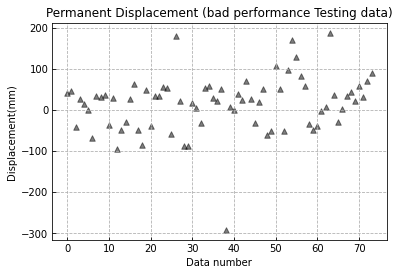

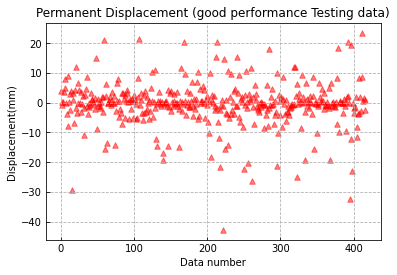

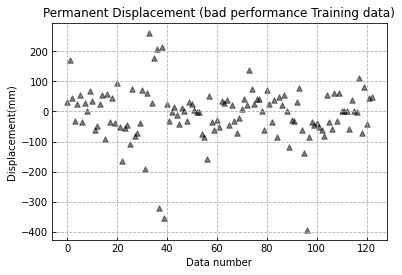

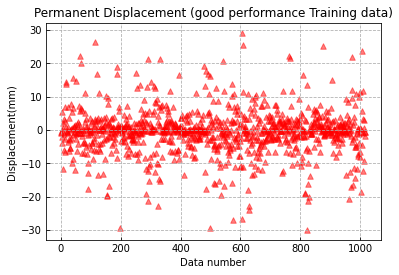

In [64]:
plt.figure()
plt.scatter((np.arange(Nonlinearity_Bad_test.shape[0])).astype(np.int8),Nonlinearity_Bad_test,s=30,c='black',marker='^',alpha=0.5,)
plt.title('Permanent Displacement (bad performance Testing data)')
plt.xlabel('Data number')
plt.ylabel('Displacement(mm)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

plt.figure()
plt.scatter(np.arange(Nonlinearity_Good_test.shape[0]),Nonlinearity_Good_test,s=30,c='r',marker='^',alpha=0.5,)
plt.title('Permanent Displacement (good performance Testing data)')
plt.xlabel('Data number')
plt.ylabel('Displacement(mm)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

plt.figure()
plt.scatter((np.arange(Nonlinearity_Bad_train.shape[0])).astype(np.int8),Nonlinearity_Bad_train,s=30,c='black',marker='^',alpha=0.5,)
plt.title('Permanent Displacement (bad performance Training data)')
plt.xlabel('Data number')
plt.ylabel('Displacement(mm)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

plt.figure()
plt.scatter(np.arange(Nonlinearity_Good_train.shape[0]),Nonlinearity_Good_train,s=30,c='r',marker='^',alpha=0.5,)
plt.title('Permanent Displacement (good performance Training data)')
plt.xlabel('Data number')
plt.ylabel('Displacement(mm)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')